In [1]:
import automatization
from automatization.ple_statistics import PleAuto
import pandas as pd
import os
import time
import json
from importlib import reload
import numpy as np
from automatization.ple_statistics import PleAuto
from matplotlib import pyplot as plt
reload(automatization.ple_statistics)
from automatization.ple_statistics import PleAuto
from scipy.constants import speed_of_light
import pickle
from pathlib import Path

In [3]:
pa = PleAuto(
    ple_gui, 
    ple_optimize_logic, 
    laser_scanner_logic,
    poi_manager_logic, 
    scanning_optimize_logic, 
    spectrometer, 
    spectrometerlogic,
    cobolt,
    ibeam_smart
)

In [4]:
# constraints
scan_range_constr = laser_scanner_logic.scanner_constraints.axes["a"].value_range

In [5]:
high_finesse_wavemeter_remote.start_acquisition()

0

In [25]:
# factor_sigma = 0.509
pa.go_to_ple_target(scan_range_constr[0])
time.sleep(5)
w1 = high_finesse_wavemeter_remote.get_current_wavelength()


In [26]:

pa.go_to_ple_target(scan_range_constr[1])
time.sleep(5)
w2 = high_finesse_wavemeter_remote.get_current_wavelength()

factor_sigma = (w2 - w1) * 1000 / 26 #GHz 

In [23]:
(w2 - w1) * 1000

12.58373030225357

In [27]:
factor_sigma 

0.4854299524153633

In [5]:
factor_sigma = 0.5014115582119197

In [28]:
scanning_optimize_logic._backwards_line_resolution = 20

-7

In [41]:
pulsestreamer

<qudi.hardware.swabian_instruments.pulse_streamer.PulseStreamer(0x1caa98c3a30) at 0x000001CAADAAB640>

In [43]:
#prepare
#switch off green and turn on the 405 nm repump
ibeam_smart.disable()

cobolt.enable_modulated()
cobolt.set_laser_modulated_power(power = 5)

center_v = laser_controller_remote.etalon_voltage
red_v = center_v + 0.3
blue_v = center_v - 0.3
eta_volts = [center_v, red_v, blue_v]

results = []

power_steps = 3 * np.logspace(1.5, 2, 10, endpoint=True).astype(int)[::-1]
folder = r"C:\Users\yy3\Documents\data\Vlad\197\2R\auto"
folder = os.path.join(folder, r"auto_1_0")
if not os.path.exists(folder):
    os.mkdir(folder) 

for poi_name in poi_manager_logic.poi_names[:5]:
    if poi_name == "ref":
        continue
    laser_controller_remote.etalon_voltage = center_v
    results_poi = {}
    os.mkdir(folder_defect := os.path.join(folder, poi_name))
    results_poi["poi_name"] = poi_name
    results_poi["factor_sigma"] = factor_sigma
    
    # go to a defect
    pa.set_resonant_power(power = 300)
    time.sleep(1)

     #configure slow scanning for the wavemeter scanning optimizations
    switchlogic.set_state("ScanningMode", 'Wavemeter')
    # x - y - z- fine scan to find the resonance
    seqs = {str(seq): idx for idx, seq in enumerate(scanner_gui._osd.settings_widget.available_opt_sequences)}
    scanner_gui._osd.settings_widget.optimize_sequence_combobox.setCurrentIndex(seqs["x, y, z"])

    scanner_gui._osd.change_settings({'scan_frequency': {"x": 5, "y": 5, "z": 5},
                                    "scan_resolution": {"x": 80, "y": 80, "z":80},
                                    "scan_range": {"x": 2.5e-6, "y": 2.5e-6, "z": 4.5e-6}})
    scanner_gui._osd.accept()

    time.sleep(1)
    pa.go_to_poi(poi_name, opt_times=1)
    

    switchlogic.set_state("ScanningMode", 'NI')
    time.sleep(0.2)

    #Check how the PLE look like
    res = pa.do_ple_scan(lines = 1)
    pa.save_ple(tag = "full_range",
            poi_name=poi_name, folder_name=folder_defect)
    time.sleep(0.5)
    results_poi.update({
        "ple_scans" : {
        "full_range" : ple_data_logic.last_saved_files_paths 
            }
        })
    for eta_v in eta_volts:
        laser_controller_remote.etalon_voltage = eta_v
        time.sleep(0.5)
        if (
            res["center"].stderr > 1e3 or 
            res["sigma"].stderr > res["sigma"].value or 
            res["sigma"].value > 1e3 or
            res["center"].value - 5 * res["sigma"].value < scan_range_constr[0] or 
            res["center"].value + 5 * res["sigma"].value > scan_range_constr[1]
            ): 
            print("NO PLE or it is at the rim")
            pa.save_ple(tag = f"failed_PLE_scan_eta_v_{eta_v}",
                poi_name=poi_name, folder_name=folder_defect)
            
            continue
        else:
            break
    #since there is a PLE -- optimize_all
    pa.go_to_ple_target(res["center"].value)
    #get the center wavelength:
    pa.optimize_ple()
    time.sleep(0.5)
    wavelength = high_finesse_wavemeter_remote.get_current_wavelength()
    results_poi["wavelength, THz"] = float(wavelength)

    time.sleep(0.5)

    scanner_gui._osd.settings_widget.optimize_sequence_combobox.setCurrentIndex(seqs["xy, z"])
    scanner_gui._osd.change_settings({'scan_frequency': {"x": 25, "y": 25, "z": 25},
                                        "scan_resolution": {"x": 15, "y": 15, "z":80},
                                        "scan_range": {"x": 1e-6, "y": 1e-6, "z": 4e-6}})
    
    scanner_gui._osd.accept()
    time.sleep(0.5)
    pa.optimize_all()
    
    #Now we now where the defect is
    results_poi["xyz"] = tuple(float(coord) for coord in poi_manager_logic.poi_anchors[poi_name])
    

    pa.set_resonant_power(power = power_steps[1])

    time.sleep(1)
    res = pa.do_ple_scan(lines = 1)

    fine_scan_range = ( 
        res["center"].value - 8 * res["sigma"].value ,
        res["center"].value + 8 * res["sigma"].value
                    )
    time.sleep(1)
    res = pa.do_ple_scan(lines = 1, in_range=fine_scan_range)
    
    scan_range_sat = ( 
        res["center"].value - 4 * res["sigma"].value ,
        res["center"].value + 4 * res["sigma"].value
                    )
    time.sleep(1)
    res = pa.do_ple_scan(lines = 1, in_range=scan_range_sat)
    scan_range_sat = ( 
        res["center"].value - 4 * res["sigma"].value ,
        res["center"].value + 4 * res["sigma"].value
                    )
    scan_range_sat_sigma = res["sigma"].value
    time.sleep(1)
    
    pa.save_ple(tag = "4sigma_range",
                poi_name=poi_name, folder_name=folder_defect)
    time.sleep(0.5)

    results_poi.update({
        "ple_scans" : {
        "5sigma_range" : ple_data_logic.last_saved_files_paths 
        }
    })


    # now we run saturation with a cw repump
    os.mkdir(saturation_folder := os.path.join(folder_defect, "saturation"))
    results_poi["saturation"] = {}
    idx_no_ple = None
    
    # #405 repump
    cobolt.enable_modulated()
    cobolt.set_laser_modulated_power(power = 5)
    #cobolt.disable_modulated() #leave only 450nm ON
    for idx, power in enumerate(power_steps):
        os.mkdir(power_folder := os.path.join(saturation_folder, f"{power}"))
        pa.set_resonant_power(power = power)
        time.sleep(1)
        #fine_scan_range = scan_range_sat
        #res = pa.do_ple_scan(lines = 1, in_range=scan_range_sat)
        fine_scan_range = ( 
            res["center"].value - 2 * scan_range_sat_sigma ,
            res["center"].value + 2 * scan_range_sat_sigma
                        )
        
        res = pa.do_ple_scan(lines = 3, in_range=fine_scan_range)
        time.sleep(1)
        #save_results
        pa.save_ple(tag = f"{power}",
            poi_name=poi_name, folder_name=power_folder)
        #save_plots
        if res["center"].stderr is None or res["sigma"].stderr is None or res["sigma"].value is None:
            idx_no_ple = idx
            break
        if res["center"].stderr > 1e3 or res["sigma"].stderr * 4 > res["sigma"].value or res["amplitude"].stderr * 3 > res["amplitude"].value or res["amplitude"].value < 3000: 
            #ple is gone.
            idx_no_ple = idx
            break

        
        #get the center wavelength:
        
        pa.go_to_ple_target(res["center"].value)
        pa.optimize_ple()
        wavelength = high_finesse_wavemeter_remote.get_current_wavelength()

        # #charge_lifetime:
        # for i in range(10):
        #     pa.optimize_ple()
        #     time.sleep(5)

        results_poi.update({"saturation": 
                            {f"{power}":
                                {"scan_data": ple_data_logic.last_saved_files_paths,
                                "sigma": res["sigma"].value,
                                "sigma_stderr": res["sigma"].stderr,
                                "wavelength": wavelength
                                }
                                }})
    if idx_no_ple is None:
        continue
    
    # # photostability study
    os.mkdir(photostability_folder := os.path.join(folder_defect, "photostability"))
    results_poi["photostability"] = {}
    #for color in ["violet", "blue", "green"]:
    color = "violet"
    
    res = pa.do_ple_scan(lines = 1, in_range=scan_range_sat)
    fine_scan_range = ( 
            res["center"].value - 2 * scan_range_sat_sigma ,
            res["center"].value + 2 * scan_range_sat_sigma
                        )
    
    cobolt.disable_modulated()
    
    for i in range(idx_no_ple):
        idx_no_ple_checked = idx_no_ple - i
        pa.set_resonant_power(power = int(power_steps[idx_no_ple_checked])) #take the last but one visible ple power
        #reionize with blue
        
        pa.one_pulse_repump(color)
        time.sleep(0.5)
        res = pa.do_ple_scan(lines = 20, in_range=fine_scan_range)
        #fine_scan_range = ( 
        #res["center"].value - scan_range_sat,
        #res["center"].value + scan_range_sat
        #        )
        if res["center"].stderr is None or res["sigma"].stderr is None or res["sigma"].value is None or res["amplitude"].value is None or res["amplitude"].stderr is None:
    
                continue
        if res["center"].stderr > 1e3 or res["sigma"].stderr * 4 > res["sigma"].value or res["amplitude"].stderr * 3 > res["amplitude"].value: 
                #ple is gone.
    
                continue
    
        pa.save_ple(tag = f"{power}_inited_{color}",
        poi_name=poi_name, folder_name=photostability_folder)
        time.sleep(1)
        results_poi.update({"photostability": {
                        "charge_initializer": color,
                        "power": power,
                        "scan_data": ple_data_logic.last_saved_files_paths,
                        "sigma": res["sigma"].value,
                        "sigma_stderr": res["sigma"].stderr
                        }}
                        )
        break
    # #no we now the power where we still see the ple
    #os.mkdir(photostability := os.path.join(folder_defect, "photostability_405"))
    

    # cobolt.enable_modulated()
    # cobolt.set_laser_modulated_power(power = 5)
    # pa.set_resonant_power(power = power_steps[idx_no_ple_checked])
    # time.sleep(1)
    # res = pa.do_ple_scan(lines = 1, in_range=fine_scan_range)

    # #ple_gui._osd.change_settings({"scan_range": {"a": 5000}}) # 3GHz
    # #ple_gui._osd.accept()

    #  #take the last but one visible ple power
    # #reionize with blue
    # pa.one_pulse_repump("blue")
    # fine_scan_range = ( 
    # res["center"].value - 5 * res["sigma"].value ,
    # res["center"].value + 5 * res["sigma"].value
    #             )
    # time.sleep(1)
    # res = pa.do_ple_scan(lines = 1, in_range=fine_scan_range)
    # time.sleep(1)
    # pa.save_ple(tag = f"no_repump_{power_steps[idx_no_ple_checked]}", folder_name=folder_defect) 


    # #no repump saturation

    # os.mkdir(no_repump_saturation := os.path.join(folder_defect, "no_repump_saturation"))
    # idx_no_ple_ohne_repump = None
    # for idx, power in enumerate(power_steps[idx_no_ple_checked : ]):
    
    #     pa.set_resonant_power(power = power)
    #     time.sleep(1)
    #     fine_scan_range = ( 
    #     res["center"].value - scan_range_sat ,
    #     res["center"].value + scan_range_sat
    #                 )
    #     pa.one_pulse_repump("blue")
    #     time.sleep(0.5)
    #     res = pa.do_ple_scan(lines = 5, in_range=fine_scan_range)
    #     time.sleep(1)
    #     #save_results
    #     pa.save_ple(tag = f"{power}",
    #         poi_name=poi_name, folder_name=no_repump_saturation)
    #     #save_plots
    #     if res["center"].stderr is None or res["sigma"].stderr is None or res["sigma"].value is None:
    #         idx_no_ple_ohne_repump = idx
    #         break
    #     if res["center"].stderr > 1e3 or res["sigma"].stderr * 4 > res["sigma"].value or res["amplitude"].stderr * 3 > res["amplitude"].value: 
    #         #ple is gone.
    #         idx_no_ple_ohne_repump = idx
    #         break

    #     #get the center wavelength:
        
    #     pa.go_to_ple_target(res["center"].value)
    #     pa.optimize_ple()
    #     wavelength = high_finesse_wavemeter_remote.get_current_wavelength()

    #     # #charge_lifetime:
    #     # for i in range(10):
    #     #     pa.optimize_ple()
    #     #     time.sleep(5)

    #     results_poi.update({"no_repump_saturation": 
    #                         {f"{power}":
    #                             {"scan_data": ple_data_logic.last_saved_files_paths,
    #                             "sigma": res["sigma"].value,
    #                             "sigma_stderr": res["sigma"].stderr,
    #                             "wavelength": wavelength
    #                             }
    #                             }})
    # if idx_no_ple_ohne_repump is None:
    #     continue
    # power_ = power_steps[idx_no_ple_checked : ][idx_no_ple_ohne_repump - 1]
    # pa.set_resonant_power(power = power_)
    # time.sleep(1)
    # pa.one_pulse_repump("blue")
    # time.sleep(0.5)
    # res = pa.do_ple_scan(lines = 20, in_range=fine_scan_range)
    # time.sleep(1)
    # #save_results
    # pa.save_ple(tag = f"lowest_power_{power_}",
    #     poi_name=poi_name, folder_name=folder_defect)

    # results_poi["lowest_power_scan"] = ple_data_logic.last_saved_files_paths


    # take spectrum to estimate SOC
    pa.set_resonant_power(power = 0)
    time.sleep(2)
    ibeam_smart.enable()
    cobolt.enable_modulated()
    cobolt.set_laser_modulated_power(power = 100)
    pa.set_resonant_power(power = 0)
    time.sleep(1)
    pa.take_spectrum()

    pa.save_spectrum(name_tag=f"{poi_name}_blueNgreen", folder_path=folder_defect)
    results_poi["spectrum_data"] = spectrometerlogic.last_saved_path

    spectrometer._mw.data_widget.fit_widget.sigDoFit.emit("DoubleLorentzian")
    time.sleep(0.2)
    # spectrometer.fit_results.params["center_1"].value
    if spectrometer.fit_results is not None:
        params = spectrometer.fit_results.params
        results_poi["SOC, GHz"] = float(speed_of_light / params["center_2"].value - speed_of_light / params["center_1"].value)

    ibeam_smart.disable()
    #cobolt.disable_modulated()
    cobolt.enable_modulated()
    cobolt.set_laser_modulated_power(power = 5)

    with open(os.path.join(folder_defect, f'results_{poi_name}'), 'wb') as handle:
        pickle.dump(results_poi, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print("Hi")

Hi


PROCESSING

In [ ]:

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle='--')
plt.rc('grid', color='#E68F6B')


In [ ]:
defs = os.listdir(folder)
dics = []
for df in defs:
    dct = [d for d in os.listdir(os.path.join(folder, df)) if "results" in d]
    if len(dct) > 0:
        dics.append(dct[0])

In [ ]:
dics

['results_def10', 'results_def12', 'results_def13', 'results_def14', 'results_def16', 'results_def18', 'results_def19', 'results_def2', 'results_def22', 'results_def23', 'results_def24', 'results_def25', 'results_def28', 'results_def29', 'results_def31', 'results_def4', 'results_def5', 'results_def6', 'results_def7', 'results_def8', 'results_def9']

In [ ]:
wlngths = []
SOCs = []
ples = []
for def_ in defs:
        if os.path.exists(os.path.join(folder, def_, f'results_{def_}')):
                with open(os.path.join(folder, def_, f'results_{def_}'), 'rb') as handle:
                        ddd = pickle.load(handle)
                wlngths.append(ddd["wavelength, THz"])
                SOCs.append(ddd["SOC, GHz"])
                ples.append(ddd[""])

In [ ]:
ddd["ple_scans"]["5sigma_range"]["cummulative_ch_APD111"]

'C:\\Users\\yy3\\Documents\\data\\SnV\\cooldown_06_03_2023_95NA\\197\\2R\\auto_D\\def9\\saturation\\20230316-2338-12__cummulative_1D-scan_with_a_axes_from_channel_APD111_def9_300.dat'

In [ ]:
from ast import literal_eval as make_tuple
def get_scan_range(file_name):
    range_ = ""
    with open(file_name, "r") as f:
        for line in f.readlines():
            if "scan range" in line:
                range_ = line
    return make_tuple(range_.strip().split("=")[-1])

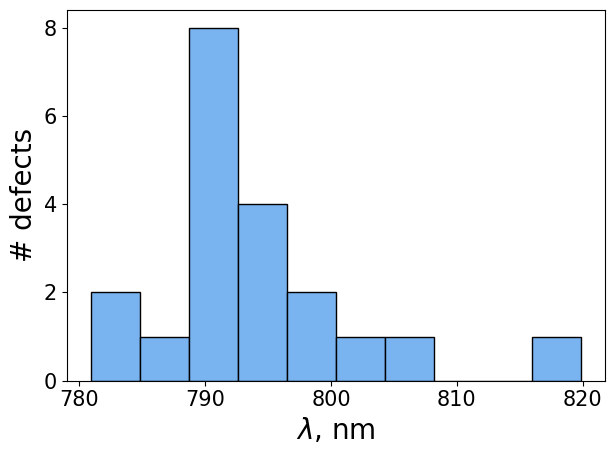

In [ ]:
SOCs = np.array(SOCs)
SOCs = SOCs[SOCs > 0]
plt.hist(SOCs, bins=10, ec="black", fc="#79B3F0")
plt.xlabel(r'$\lambda$, nm')
plt.ylabel(r'# defects')
plt.tight_layout()
plt.savefig(r"C:\Users\yy3\Documents\data\plots\SnV_1500_197_2R.png", dpi=300)

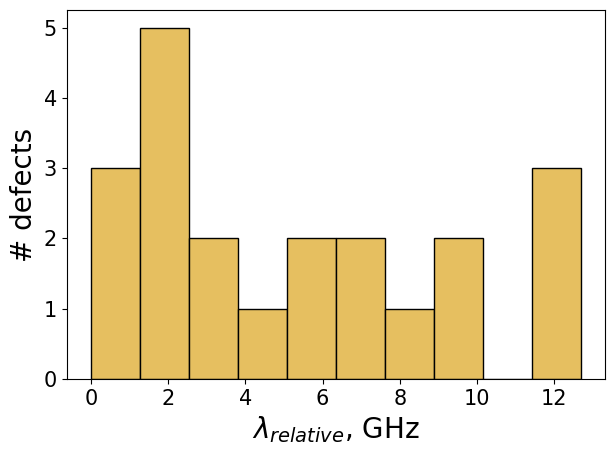

In [ ]:
wlngths = np.array(wlngths)
wlngths = wlngths - min(wlngths)
plt.hist(wlngths * 1000, bins=10, ec="black", fc="#E6BF60")
plt.xlabel(r'$\lambda_{relative}$, GHz')
plt.ylabel(r'# defects')
plt.tight_layout()
plt.savefig(r"C:\Users\yy3\Documents\data\plots\SnV_1500_197_2R_lam.png", dpi=300)